In [1]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [2]:
%load_ext blackcellmagic

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [9]:
from scr.params.sys import RAND_SEED, DEVICE

In [5]:
from scr.preprocess.data_process import split_protrain_loader
from scr.model.pytorch_model import LinearRegression
from scr.model.train_test import train, test
from scr.encoding.encoding_classes import ESMEncoder

In [6]:
dataset_path="data/proeng/gb1/two_vs_rest.pkl"

In [16]:
train_loader, val_loader = split_protrain_loader(
    dataset_path=dataset_path,
    encoder_class=ESMEncoder,
    encoder_name="esm1b_t33_650M_UR50S",
    embed_layer=33,
    flatten_emb="mean",
    subset_list=["train", "val"],
)

Loading esm1b_t33_650M_UR50S using 33 layer embedding


Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main
100%|██████████| 3/3 [03:58<00:00, 79.43s/it]
Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


Loading esm1b_t33_650M_UR50S using 33 layer embedding


100%|██████████| 1/1 [00:27<00:00, 27.71s/it]


In [21]:
train_loader

In [11]:
encoder = ESMEncoder

In [29]:
model = LinearRegression(input_dim=1280, output_dim=1)
model.to(DEVICE)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
criterion.to(DEVICE, non_blocking=True)

MSELoss()

In [30]:
epochs = 100

train_losses, val_losses = train(
    model=model, train_loader=train_loader, val_loader=val_loader,
    device=DEVICE, criterion=criterion, learning_rate=learning_rate,
    epochs=epochs)

train_mse = test(
    model=model, loader=train_loader, device=DEVICE,
    criterion=criterion)

100%|██████████| 2/2 [00:00<00:00, 546.95it/s]

[    2] loss: 1.001


In [31]:
import matplotlib.pyplot as plt

In [46]:
import numpy as np
import os

In [48]:
replace_ext(os.path.basename(dataset_path), "svg")

'two_vs_rest.svg'

In [45]:
os.path.join("results/learning_curves", "/".join(os.path.dirname(dataset_path).split("/")[1:]))

'results/learning_curves/proeng/gb1'

In [47]:
from scr.utils import checkNgen_folder, replace_ext

In [79]:
import os
def checkNgen_folder(folder_path: str) -> None:
    """
    Check if the folder or the subfolder exists
    to create a new directory if not
    
    Args:
    - folder_path: str, the folder path
    """

    split_list = folder_path.split("/")

    for p in range(len(split_list)):
        subfolder_path = "/".join(split_list[:p+1])
        if not os.path.exists(subfolder_path):
            print(f"Making {subfolder_path}...")
            os.mkdir(subfolder_path)

In [94]:
def get_folder_file_names(
    parent_folder: str,
    dataset_path: str,
    encoder_name: str,
    embed_layer: int,
    flatten_emb: bool | str,
) -> list[str]:
    """
    A function for specify folder and file names for the output given input dataset

    Args:
    - parent_folder: str, the parent result folder, such as results/train_val_test
    - dataset_path: str, full path to the input dataset, in pkl or panda readable format
        columns include: sequence, target, set, validation, mut_name (optional), mut_numb (optional)
    - encoder_name: str, the name of the encoder
    - embed_layer: int, the layer number of the embedding
    - flatten_emb: bool or str, if and how (one of ["max", "mean"]) to flatten the embedding

    Returns:
    - dataset_subfolder: str, the full path for the dataset based subfolder
    - file_name: str, the name of the file with embedding details without file extension
    """
    # path for the subfolder
    dataset_subfolder = os.path.join(
        parent_folder, "/".join(os.path.splitext(dataset_path)[0].split("/")[1:])
    )

    # check and generate the folder
    checkNgen_folder(dataset_subfolder)

    file_name = f"{encoder_name}-layer_{embed_layer}-{flatten_emb}"

    return dataset_subfolder, file_name

In [98]:
"""Script for visulizing the learning related process"""

from __future__ import annotations

import os
import numpy as np
import matplotlib.pyplot as plt

from scr.utils import checkNgen_folder, get_folder_file_names


def plot_lc(
    train_losses: np.ndarray,
    val_losses: np.ndarray,
    dataset_path: str,
    encoder_name: str,
    embed_layer: int,
    flatten_emb: bool | str,
    all_plot_folder: str = "results/learning_curves",
) -> None:
    """
    Plot and save learning curves

    Args:
    - train_losses: np.ndarry, an array of training loss
    - val_losses: np.ndarry, an array of validation loss
    - dataset_path: str, full path to the dataset, in pkl or panda readable format
        columns include: sequence, target, set, validation, mut_name (optional), mut_numb (optional)
    - encoder_name: str, the name of the encoder
    - embed_layer: int, the layer number of the embedding
    - flatten_emb: bool or str, if and how (one of ["max", "mean"]) to flatten the embedding
    - all_plot_folder: str, the parent folder path for saving all the learning curves
    """

    epochs = len(train_losses)

    plot_dataset_folder, plotname = get_folder_file_names(
        parent_folder=all_plot_folder,
        dataset_path=dataset_path,
        encoder_name=encoder_name,
        embed_layer=embed_layer,
        flatten_emb=flatten_emb,
    )

    plt.plot(range(epochs), train_losses, label="train")
    plt.plot(range(epochs), val_losses, label="val")
    plt.title(plotname)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(loc="upper right")

    plt.savefig(
        os.path.join(plot_dataset_folder, plotname + ".svg"), bbox_inches="tight"
    )

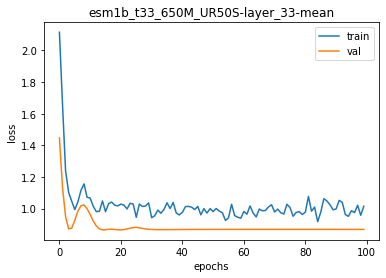

In [99]:
plot_lc(
    train_losses,
    val_losses,
    dataset_path,
    encoder_name="esm1b_t33_650M_UR50S",
    embed_layer=33,
    flatten_emb="mean",
)

In [53]:
model = LinearRegression(input_dim=1280, output_dim=1)
model.to(DEVICE)
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
criterion.to(DEVICE, non_blocking=True)

Loading esm1b_t33_650M_UR50S using 33 layer embedding


Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main
100%|██████████| 12/12 [04:22<00:00, 21.89s/it]
Using cache found in /home/t-fli/.cache/torch/hub/facebookresearch_esm_main


Loading esm1b_t33_650M_UR50S using 33 layer embedding


100%|██████████| 2/2 [00:29<00:00, 14.68s/it]


In [54]:
epochs = 100

train_losses, val_losses = train(
    model=model, train_loader=train_loader, val_loader=val_loader,
    device=DEVICE, criterion=criterion, learning_rate=learning_rate,
    epochs=epochs)

train_mse = test(
    model=model, loader=train_loader, device=DEVICE,
    criterion=criterion)

[   12] loss: 0.914



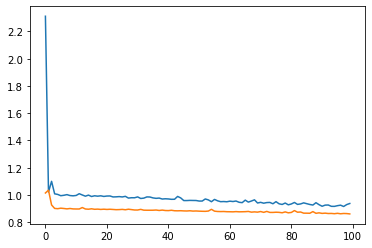

In [55]:
plt.plot(range(epochs), train_losses, range(epochs), val_losses)